In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os 

PATH = Path('/home/fergus/data/icloud_data/raw_icloud/')

def load_photo(fn):
    img = io.imread(fn)[...,:3]
    return img 

fn = [x for x in PATH.iterdir()][0]
print(fn)


/home/fergus/data/icloud_data/raw_icloud/IMG_4275.jpg


In [3]:
import tensorflow as tf

2023-07-30 14:07:15.340539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 14:07:15.844806: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-30 14:07:15.844843: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-30 14:07:15.844848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
%%bash
nvidia-smi

Sun Jul 30 14:07:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  Off |
|  0%   38C    P8    32W / 450W |     19MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from tensorflow.keras.applications.convnext import ConvNeXtTiny

In [6]:
model = tf.keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [7]:
model.outputs

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'layer_normalization')>]

# Finetuning on my dataset 

In [9]:
import fiftyone as fo


dataset = fo.load_dataset("icloud")

In [13]:
view = dataset.filter_labels("ground_truth")

TypeError: SampleCollection.filter_labels() missing 1 required positional argument: 'filter'

In [31]:
# Create a view containing only labeled samples
labeled_view = dataset.match({"('new_field',)": {"$exists": True}})
labeled_view

Dataset:     icloud
Media type:  image
Num samples: 99
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    tfrecord:       fiftyone.core.fields.BooleanField
    ('new_field',): fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
View stages:
    1. Match(filter={"('new_field',)": {'$exists': True}})

In [32]:
labeled_view[0]

KeyError: 'Accessing samples by numeric index is not supported. Use sample IDs, filepaths, slices, boolean arrays, or a boolean ViewExpression instead'

In [47]:
import matplotlib.pyplot as plt 

images, labels = [], []
for img in labeled_view:
    #print(img)
    filepath: str = img.filepath
    a_labels = []
    for classification in img["('new_field',)"].classifications:
        a_labels.append(classification.label)
    image = tf.io.decode_jpeg(tf.io.read_file(filepath))
    images.append(image)
    labels.append(a_labels)
print(len(images)),  print(len(labels))                            


99
99


(None, None)

In [51]:
# resizing 
images = [tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) for image in images]

In [53]:
images_dataset = tf.data.Dataset.from_tensor_slices(images)

In [55]:
fergus_labels = [1 if 'fergus' in label else 0 for label in labels]
labels_dataset = tf.data.Dataset.from_tensor_slices(fergus_labels)

In [57]:
dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))

In [85]:
dataset = tf.data.Dataset.from_tensor_slices((images, fergus_labels))

# Preparing new model

In [116]:

def get_model():
    inputs = model.inputs
    x = model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation=tf.nn.softmax)(x)
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(x)
    finetune_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return finetune_model
finetune_model = get_model()
finetune_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 convnext_tiny (Functional)  (None, None, None, 768)   27820128  
                                                                 
 global_average_pooling2d_5   (None, 768)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 256)               196864    
                                                                 
 dense_10 (Dense)            (None, 2)                 514       
                                                                 
Total params: 28,017,506
Trainable params: 28,017,506
Non-trainable params: 0
_______________________________________________

In [117]:
from sklearn.metrics import accuracy_score 
import numpy as np

def model_eval():
    preds = []
    for img, label in dataset:
        pred = finetune_model(img)
        preds.append(np.argmax(pred.numpy()))
    return preds

preds = model_eval()

In [118]:
accuracy_score(fergus_labels, preds)

0.7474747474747475

nice random prediction head = random guessing

# Training

In [120]:
finetune_model = get_model()
finetune_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy())
history = finetune_model.fit(dataset.batch(16), epochs=10)

Epoch 1/10
7/7 [==============================] - 17s 82ms/step - loss: 0.6931
Epoch 2/10
7/7 [==============================] - 1s 81ms/step - loss: 0.6931
Epoch 3/10
7/7 [==============================] - 1s 81ms/step - loss: 0.6931
Epoch 4/10
7/7 [==============================] - 1s 81ms/step - loss: 0.6931
Epoch 5/10
7/7 [==============================] - 1s 81ms/step - loss: 0.6931
Epoch 6/10
7/7 [==============================] - 1s 81ms/step - loss: 0.6931
Epoch 7/10
7/7 [==============================] - 1s 81ms/step - loss: 0.6931
Epoch 8/10
7/7 [==============================] - 1s 81ms/step - loss: 0.6931
Epoch 9/10
7/7 [==============================] - 1s 81ms/step - loss: 0.6931
Epoch 10/10
7/7 [==============================] - 1s 81ms/step - loss: 0.6931


In [122]:
history.history

{'loss': [0.6931484341621399,
  0.693147599697113,
  0.6931474208831787,
  0.6931473016738892,
  0.6931474208831787,
  0.693147599697113,
  0.6931473612785339,
  0.6931471228599548,
  0.6931470036506653,
  0.6931470036506653]}

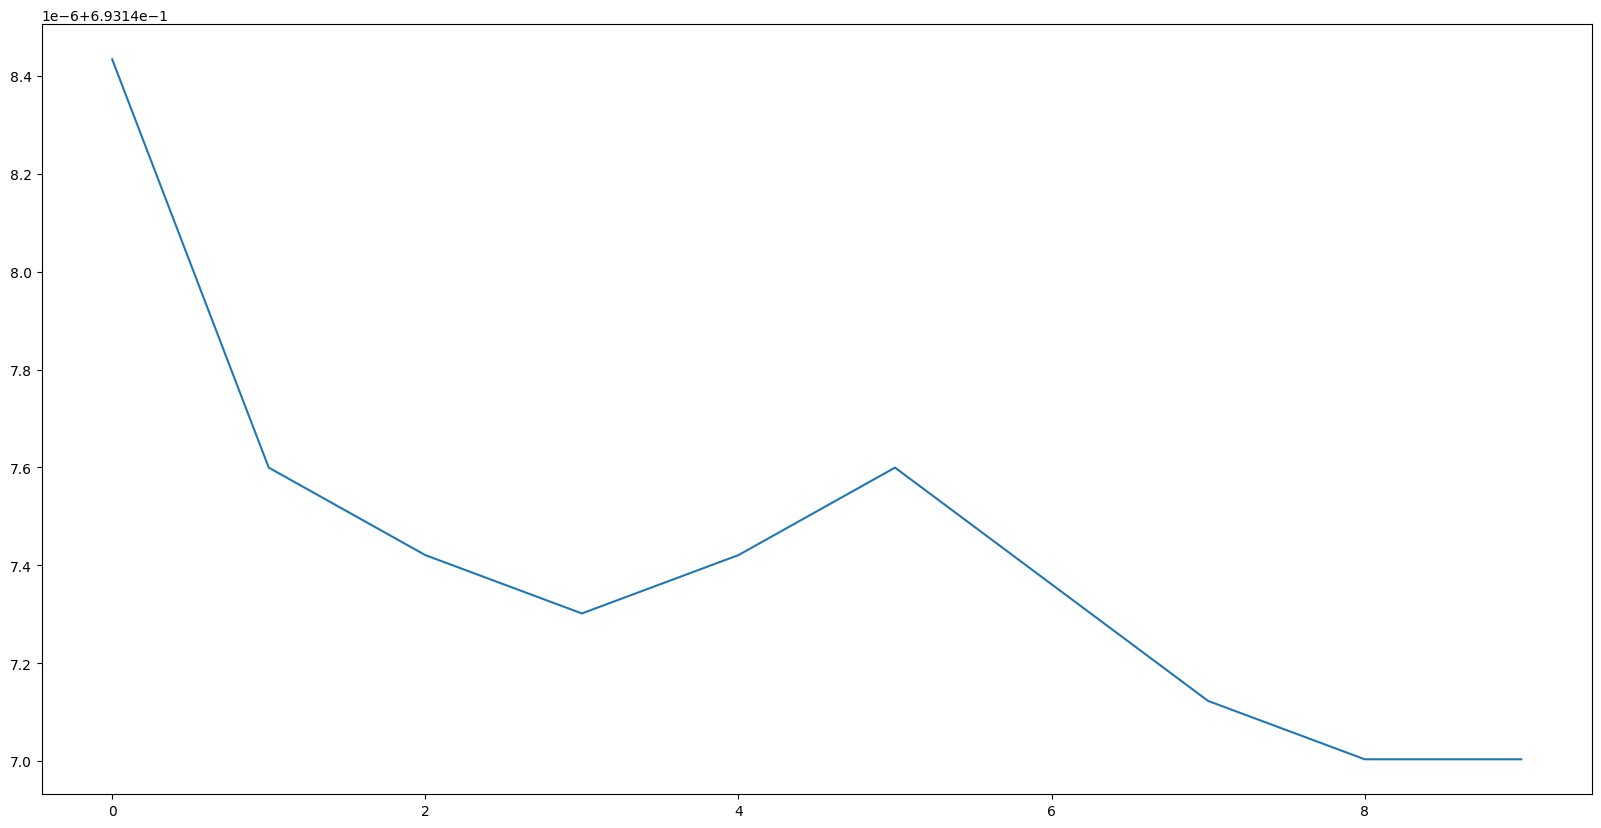

In [125]:
fig, axs = plt.subplots(1,1,figsize=(20,10))
axs.plot(np.arange(10), history.history['loss'])

loss doesn't change, but have no data. 